# CIFAR-100 With ResNet Benchmarking

Notebook based on the following sources:
- https://medium.com/@damian.c036/training-model-to-classify-cifar100-with-resnet-4512d7a596a1
- https://jovian.ai/damian-c036/cifar100-final-project/v/5

The purpose of this notebook is to benchmark various PC setups from a machine learning point of view by training a standard image recognition model (ResNet) on CIFAR-100 dataset.

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision.datasets import CIFAR100, ImageFolder
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import InterpolationMode
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = CIFAR100(root='data/', download=True, transform=ToTensor())

transform1 = transforms.Compose([transforms.RandomResizedCrop(size=32, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=InterpolationMode.BILINEAR), ToTensor()])
datasetplus = CIFAR100(root='data/', download=True, transform=transform1)

test_dataset = CIFAR100(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
dataset_size = len(dataset) + len(datasetplus)
test_dataset_size = len(test_dataset)
dataset_size, test_dataset_size, dataset[0][0].shape

(100000, 10000, torch.Size([3, 32, 32]))

In [4]:
classes = dataset.classes
num_classes = len(dataset.classes)
print(num_classes)
print(classes)

100
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tr

Label:  cattle (19)


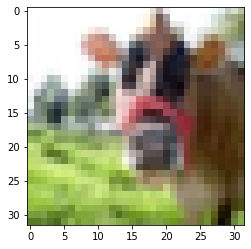

In [5]:
def show_samples(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_samples(*dataset[0])

Label:  cattle (19)


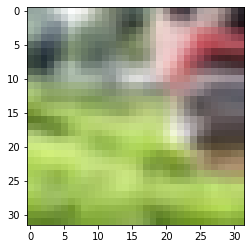

In [6]:
show_samples(*datasetplus[0])

Label:  mushroom (51)


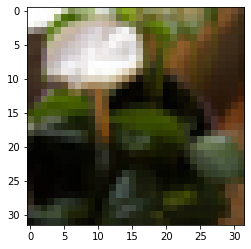

In [7]:
show_samples(*dataset[1002])

Label:  mushroom (51)


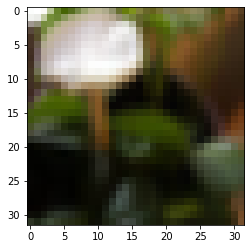

In [8]:
show_samples(*datasetplus[1002])

In [9]:
random_seed = 42
torch.manual_seed(random_seed);

val_size = 10000
train_size = dataset_size - val_size

train_ds, val_ds = random_split((dataset+datasetplus), [train_size, val_size])
len(train_ds), len(val_ds)

(90000, 10000)

In [10]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

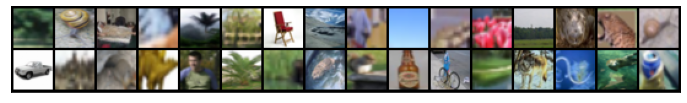

In [11]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

show_batch(train_dl)

In [12]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch 
    out = self(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss
  
  def validation_step(self, batch):
    images, labels = batch 
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}
  
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
      epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
class CIFAR100Model(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = torchvision.models.resnet34()
    num_ftrs = self.network.fc.in_features
    self.network.fc = nn.Linear(num_ftrs, 100)
  
  def forward(self, xb):
    return self.network(xb)
            
model = CIFAR100Model()
model

CIFAR100Model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [14]:
for images, labels in train_dl:
  print('images.shape:', images.shape)
  out = model(images)
  print('out.shape:', out.shape)
  print('out[0]:', out[0])
  break

images.shape: torch.Size([32, 3, 32, 32])
out.shape: torch.Size([32, 100])
out[0]: tensor([ 5.6843e-01, -4.1312e-01, -2.6756e+00, -1.6732e+00,  8.1161e-01,
        -4.9032e-01,  2.4557e+00, -1.6076e+00, -6.5258e-01, -2.0666e-01,
        -1.5746e+00, -5.4695e-01,  3.8103e-01, -1.5525e+00,  8.6200e-01,
        -8.6665e-01, -4.1586e-01, -6.2753e-01,  8.4960e-01, -1.4561e+00,
        -2.0831e-01, -9.4006e-01,  1.8668e+00, -4.4547e-01,  1.2232e-01,
         5.6821e-01,  2.2329e-02,  3.6322e-01,  8.7328e-01, -1.4069e-02,
        -1.3038e+00, -3.4881e-01,  3.4803e-01,  3.7479e-01,  1.1201e+00,
         2.3863e+00,  2.2557e-01, -8.1468e-01,  2.3690e-01,  1.1043e+00,
        -1.1792e+00,  1.5048e-03, -2.1129e-01,  6.3326e-01,  5.8939e-01,
         7.4996e-01,  1.3154e+00,  1.5555e-02,  1.2348e-01,  2.5181e-01,
        -1.8106e+00,  5.1191e-01, -6.0605e-01,  1.2397e+00,  4.5882e-01,
        -1.0015e+00,  2.9690e-01, -1.5507e+00,  1.0731e-01,  4.1349e-01,
         1.1585e+00,  1.8783e-01, -7.6064

In [15]:
print(f'GPU is {"available" if torch.cuda.is_available else "unavailable"}')
print(f'GPU count: {torch.cuda.device_count()}')
print(f'Currently used GPU: {torch.cuda.get_device_name()}')

GPU is available
GPU count: 1
Currently used GPU: NVIDIA GeForce GTX 1650 with Max-Q Design


In [16]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')
    
def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
      
  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl: 
        yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, 
    weight_decay=0, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
  for epoch in range(epochs):
    # Training Phase 
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # Validation phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [18]:
model = to_device(CIFAR100Model(), device)
evaluate(model, val_dl)

{'val_loss': 4.711432933807373, 'val_acc': 0.010947451926767826}

In [19]:
# For this model we gonna use Adam Optimization
opt_func = torch.optim.Adam

In [20]:
history = fit(8, 1e-3, model, train_dl, val_dl, 5e-4, opt_func)

Epoch [0], train_loss: 3.9127, val_loss: 3.6167, val_acc: 0.1474
Epoch [1], train_loss: 3.3073, val_loss: 3.2128, val_acc: 0.2148
Epoch [2], train_loss: 2.9723, val_loss: 3.0225, val_acc: 0.2545
Epoch [3], train_loss: 2.7750, val_loss: 2.8626, val_acc: 0.2918
Epoch [4], train_loss: 2.6516, val_loss: 2.6219, val_acc: 0.3301
Epoch [5], train_loss: 2.5544, val_loss: 2.9513, val_acc: 0.2942
Epoch [6], train_loss: 2.4745, val_loss: 2.5742, val_acc: 0.3448
Epoch [7], train_loss: 2.4160, val_loss: 2.6489, val_acc: 0.3347


In [21]:
history = fit(10, 1e-5, model, train_dl, val_dl, 5e-4, opt_func)

Epoch [0], train_loss: 2.1757, val_loss: 2.2391, val_acc: 0.4187
Epoch [1], train_loss: 2.0809, val_loss: 2.1920, val_acc: 0.4333
Epoch [2], train_loss: 2.0401, val_loss: 2.1720, val_acc: 0.4338


KeyboardInterrupt: 

In [ ]:
history = fit(5, 1e-4, model, train_dl, val_dl, 5e-4, opt_func)

In [ ]:
history = fit(15, 1e-4, model, train_dl, val_dl, 5e-4, opt_func)

In [ ]:
history = fit(25, 1e-5, model, train_dl, val_dl, 5e-4, opt_func)